# License Plate Recognition

In [1]:
# import the required libraries
import os
import pandas as pd
import cv2
import matplotlib.pyplot as plt

In [2]:
# Load the detection (bbox) and recognition (text) data
bbox_df = pd.read_csv("Licplatesdetection_train.csv")
ocr_df = pd.read_csv("Licplatesrecognition_train.csv")

In [3]:
# Merge them on image id
data_df = pd.merge(bbox_df, ocr_df, on='img_id')

The Function of visualizing the data of license plate at car

In [4]:
def visualize_bbox(img_folder, img_id, xmin, ymin, xmax, ymax):
    img_path = os.path.join(img_folder, img_id)
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
    plt.imshow(image)
    plt.title("License Plate Bounding Box")
    plt.axis('off')
    plt.show()

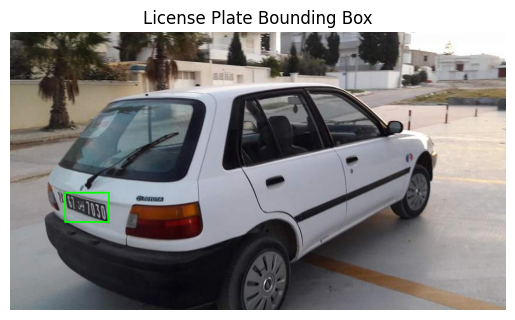

In [5]:
# Example (change path to your local folder)
img_folder = "license_plates_detection_train"
sample = data_df.iloc[0]
visualize_bbox(img_folder, sample['img_id'], sample['xmin'], sample['ymin'], sample['xmax'], sample['ymax'])

create a folder to save the cropped plates

In [6]:
cropped_folder = "cropped_plates"
os.makedirs(cropped_folder, exist_ok=True)

The Functin of the croppig and saving the plates

In [7]:
def crop_and_save_plate(row):
    path = os.path.join(img_folder, row['img_id'])
    image = cv2.imread(path)
    if image is None:
        return None
    xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']
    cropped = image[ymin:ymax, xmin:xmax]
    save_path = os.path.join(cropped_folder, row['img_id'])
    cv2.imwrite(save_path, cropped)
    return save_path

In [8]:
# Apply to all rows
data_df['cropped_path'] = data_df.apply(crop_and_save_plate, axis=1)

### Data preprocessing

In [9]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

In [10]:
# Set image size for OCR input
IMG_WIDTH, IMG_HEIGHT = 100, 40

In [11]:
# Prepare arrays
processed_images = []
labels = []

In [12]:
# Filter out rows where image path is missing
valid_data = data_df[data_df['cropped_path'].notnull()]

for _, row in valid_data.iterrows():
    image_path = row['cropped_path']
    label_text = row['text']

    if not os.path.exists(image_path):
        continue  # skip if image path invalid

    # Read, convert to grayscale, resize, and normalize
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
    image = image / 255.0  # Normalize to [0, 1]

    processed_images.append(image)
    labels.append(label_text)

In [13]:
# Convert to NumPy arrays
X = np.array(processed_images).reshape(-1, IMG_HEIGHT, IMG_WIDTH, 1)  # Add channel dimension
y = np.array(labels)

In [14]:
# Encode labels as categorical (this version treats each license plate as a class)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

In [15]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

print(f"Prepared {len(X)} images for OCR model.")

Prepared 890 images for OCR model.


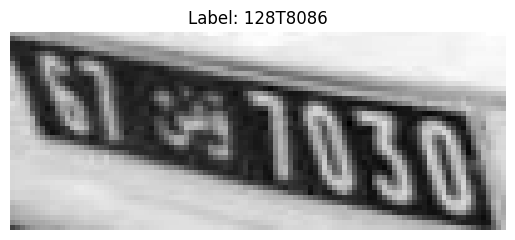

In [16]:
plt.imshow(X[0].reshape(IMG_HEIGHT, IMG_WIDTH), cmap='gray')
plt.title(f"Label: {label_encoder.inverse_transform([np.argmax(y_categorical[0])])[0]}")
plt.axis('off')
plt.show()

### Model Building of Cropped License Plates 

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

In [18]:
# Define a simple CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(40, 100, 1)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dense(len(label_encoder.classes_), activation='softmax')  # One class per license plate string
])

C:\Users\A.JASWANTH\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
# Compile model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
# Train model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.0042 - loss: 6.3921 - val_accuracy: 0.0000e+00 - val_loss: 6.3861
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.0103 - loss: 6.3746 - val_accuracy: 0.0000e+00 - val_loss: 6.4736
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.0081 - loss: 6.3247 - val_accuracy: 0.0000e+00 - val_loss: 6.4966
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.0080 - loss: 6.2554 - val_accuracy: 0.0000e+00 - val_loss: 6.8529
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.0049 - loss: 6.1551 - val_accuracy: 0.0000e+00 - val_loss: 7.0436
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.0203 - loss: 6.0104 - val_accuracy: 0.0000e+00 - val_loss: 7.4615
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.0218 - loss: 5.7585 - val_accuracy: 0.0000e+00 - val_loss: 8.0705
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.0924 - loss: 5.208

### Data Preprocessing of Character in License Plates

In [21]:
def extract_characters(image, min_width=10, min_height=20):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    char_regions = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if w >= min_width and h >= min_height:
            char_image = image[y:y+h, x:x+w]
            char_regions.append((x, char_image))  # include x for sorting

    # Sort by x (horizontal position)
    char_regions = sorted(char_regions, key=lambda item: item[0])

    # Return only the character images
    characters = [img for _, img in char_regions]
    return characters


In [22]:
# Prepare character images and labels
char_images = []
char_labels = []

# Go through each license plate and extract characters
for _, row in valid_data.iterrows():
    image_path = row['cropped_path']
    label_text = row['text']

    if not os.path.exists(image_path):
        continue  # skip if image path invalid

    image = cv2.imread(image_path)
    characters = extract_characters(image)

    for i, char_image in enumerate(characters):
        # Resize character image
        char_image = cv2.cvtColor(char_image, cv2.COLOR_BGR2GRAY)
        char_image = cv2.resize(char_image, (IMG_WIDTH, IMG_HEIGHT))
        char_image = char_image / 255.0  # Normalize

        # Append image and corresponding label (character)
        char_images.append(char_image)
        char_labels.append(label_text[i])


In [23]:
# Convert to numpy arrays
X_chars = np.array(char_images).reshape(-1, IMG_HEIGHT, IMG_WIDTH, 1)
y_chars = np.array(char_labels)

In [24]:
# Encode characters as categorical labels
char_label_encoder = LabelEncoder()
y_chars_encoded = char_label_encoder.fit_transform(y_chars)
y_chars_categorical = to_categorical(y_chars_encoded)

# Split into training and testing sets
X_train_chars, X_test_chars, y_train_chars, y_test_chars = train_test_split(X_chars, y_chars_categorical, test_size=0.2, random_state=42)


### Model Building of Character in License Plates

In [25]:
# Define a simple CNN for character recognition
char_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dense(len(char_label_encoder.classes_), activation='softmax')  # One class per character
])

# Compile model
char_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
char_model.fit(X_train_chars, y_train_chars, epochs=10, batch_size=32, validation_data=(X_test_chars, y_test_chars))


Epoch 1/10


C:\Users\A.JASWANTH\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5383 - loss: 1.7853 - val_accuracy: 0.5687 - val_loss: 1.6301
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5983 - loss: 1.5560 - val_accuracy: 0.5687 - val_loss: 1.6294
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5735 - loss: 1.5934 - val_accuracy: 0.5687 - val_loss: 1.6668
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.6067 - loss: 1.4279 - val_accuracy: 0.5687 - val_loss: 1.6364
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.5991 - loss: 1.3418 - val_accuracy: 0.5640 - val_loss: 1.6533
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.6076 - loss: 1.2833 - val_accuracy: 0.5498 - val_loss: 1.7008
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.6753 - loss: 0.9959 - val_accuracy: 0.5355 - val_loss: 1.8148
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.7248 - loss: 0.8554 - val_accuracy: 0.5118 - val_loss: 1.

### Accuracy of the character recognition from the license plate

In [26]:
# Evaluate the model on the test set
loss, accuracy = char_model.evaluate(X_test_chars, y_test_chars)
print(f"Character-level recognition accuracy: {accuracy * 100:.2f}%")


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5097 - loss: 2.8368 
Character-level recognition accuracy: 53.55%
